# Install and Import Dependencies:

In [5]:
!pip install kaggle

#machine learning
!pip install catboost

     |████████████████████████████████| 60.6MB 1.2MB/s 


In [0]:
import pandas as pd
import numpy as np
import os
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import time

import matplotlib.pyplot as plt

# Import Dataset from Kaggle:

In [8]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [9]:
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 31.0MB/s]
 93% 225M/242M [00:02<00:00, 108MB/s] 
100% 242M/242M [00:02<00:00, 119MB/s]
100% 2.02G/2.03G [00:36<00:00, 19.7MB/s]
100% 2.03G/2.03G [00:37<00:00, 58.7MB/s]


In [0]:
!ls

sample_data  sample_submission.csv  test.zip  train.csv.zip


## Extract Data:

In [10]:
!unzip train.csv.zip


Archive:  train.csv.zip
  inflating: train.csv               


In [11]:
!unzip -d test/ test.zip

Archive:  test.zip
  inflating: test/seg_430e66.csv     
  inflating: test/seg_d1a281.csv     
  inflating: test/seg_05a1b0.csv     
  inflating: test/seg_f8dd7e.csv     
  inflating: test/seg_b9bdd7.csv     
  inflating: test/seg_24c1c9.csv     
  inflating: test/seg_c5abaa.csv     
  inflating: test/seg_6262c4.csv     
  inflating: test/seg_734a88.csv     
  inflating: test/seg_94a133.csv     
  inflating: test/seg_d0c280.csv     
  inflating: test/seg_d36737.csv     
  inflating: test/seg_f80e44.csv     
  inflating: test/seg_07c815.csv     
  inflating: test/seg_7c9433.csv     
  inflating: test/seg_211486.csv     
  inflating: test/seg_78ded2.csv     
  inflating: test/seg_f11f77.csv     
  inflating: test/seg_b3883e.csv     
  inflating: test/seg_3db0a8.csv     
  inflating: test/seg_81f798.csv     
  inflating: test/seg_0a45a1.csv     
  inflating: test/seg_dc188b.csv     
  inflating: test/seg_4a9e8d.csv     
  inflating: test/seg_32fc4e.csv     
  inflating: test/seg_7b2994.cs

# Data Analysis:

In [0]:
train_df = pd.read_csv('train.csv', nrows = 6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [13]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


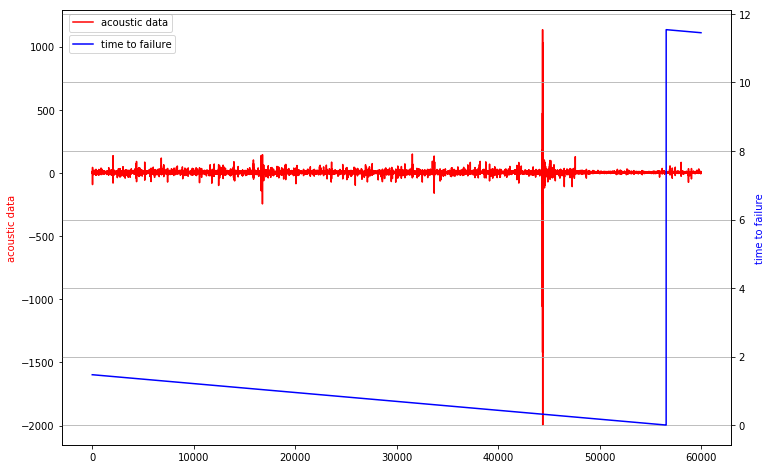

In [0]:
train_ad_sample = train_df['acoustic_data'].values[::100] # :: means skip by 100
train_ttf_sample = train_df['time_to_failure'].values[::100]

# twinx() - share same X-axis but with diff scales

fig, ax1 = plt.subplots(figsize=(12, 8))

plt.plot(train_ad_sample, color='r')
ax1.set_ylabel('acoustic data', color='r')
plt.legend(['acoustic data'], loc=(0.01, 0.95))

ax2 = ax1.twinx()

plt.plot(train_ttf_sample, color='b')
ax2.set_ylabel('time to failure', color='b')
plt.legend(['time to failure'], loc=(0.01, 0.9))

plt.grid(True)


# Feature Engineering:

In [0]:
def gen_features(X):
    strain = []
    #strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    #strain.append(X.kurtosis())
    #strain.append(X.skew())
    #strain.append(np.quantile(X,0.01))
    #strain.append(np.quantile(X,0.05))
    #strain.append(np.quantile(X,0.95))
    #strain.append(np.quantile(X,0.99))
    #strain.append(np.abs(X).min())
    strain.append(np.abs(X).max())
    #strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

# Prepare Training Data:

In [0]:
train = pd.read_csv('train.csv', iterator = True, chunksize = 150000,
                    dtype = {'acoustic_data': np.int16, 'time_to_failure': np.float64})  #Returns TextFileReader object for Iteration
X_train = pd.DataFrame()
y_train = pd.Series()


for df in train:
  ch = gen_features(df['acoustic_data'])
  X_train = X_train.append(ch, ignore_index=True)
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [66]:
X_train.describe()

,0,1,2,3,4,5,6
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,6.547788,-149.190942,163.522288,68.297997,0.125830,170.046246,5.750165
std,8.503939,265.087984,272.930331,70.532565,0.477901,296.887015,8.339211
min,2.802720,-5515.000000,23.000000,0.648602,-4.091826,23.000000,2.589085
25%,4.478637,-154.000000,92.000000,28.090227,-0.040779,94.000000,3.862810
50%,5.618798,-111.000000,123.000000,45.816625,0.085620,127.000000,4.781513
75%,6.880904,-79.000000,170.000000,78.664202,0.253930,175.000000,5.887947
max,153.703569,-15.000000,5444.000000,631.158927,4.219429,5515.000000,150.432368


In [0]:
y_train.describe()

count    4195.000000
mean        5.683670
std         3.673246
min         0.006398
25%         2.635348
50%         5.358796
75%         8.177500
max        16.103196
dtype: float64

In [0]:
# scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train) # compute the mean and standard deviation to be used for later scaling
X_train_scaled = scaler.transform(X_train)

# Training Time:

In [17]:
#random forest

rand_forest = RandomForestRegressor(n_estimators=100, criterion='mae', oob_score=True, n_jobs=-1)
start_time = time.time()
rand_forest.fit(X_train_scaled, y_train.values.flatten())
print("Training Time:", time.time()-start_time)
print('Training Score:', rand_forest.score(X_train_scaled, y_train.values.flatten()))
rand_forest.oob_score_

Time taken to train: 18.366427421569824
Training Score: 0.9023306097998793


0.3216271511096993

In [18]:
rand_forest.feature_importances_

array([0.43445577, 0.15563784, 0.115902  , 0.10873592, 0.18526847])

In [19]:
#svm

svr = SVR(kernel = 'rbf', tol = 0.01, C= 2, gamma=0.02)
start_time = time.time()
svr.fit(X_train_scaled, y_train.values.flatten())
print("Training Time:", time.time()-start_time)
print('Training Score:', svr.score(X_train_scaled, y_train.values.flatten()))

Training Time: 1.2411623001098633
Training Score: 0.3044303767636421


In [20]:
#catboost

pool = Pool(X_train, y_train)
cat_boost = CatBoostRegressor(loss_function='MAE', boosting_type='Ordered') # iterations=no. of trees
start_time = time.time()
cat_boost.fit(pool, silent=True) # don't show training | verbose
print("Time taken to train:", time.time()-start_time)
cat_boost.best_score_

Time taken to train: 11.08417272567749


{'learn': {'MAE': 2.201713625760207}}

## Using LSTM:

In [0]:
train_tfread = pd.read_csv('train.csv', iterator = True, chunksize = 150000, nrows = 6000000,
                       dtype = {'acoustic_data': np.int16, 'time_to_failure': np.float32})
X_train_seq = []
y_train_seq = []
for df in train_tfread:
  X_train_seq.append(df['acoustic_data'].to_numpy().reshape(-1,1))
  y_train_seq.append(df['time_to_failure'].values[-1])

In [30]:
X_train_seq = np.array(X_train_seq)
y_train_seq = np.array(y_train_seq)
X_train_seq.shape[1:]

(150000, 1)

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization

In [0]:
rnn = Sequential()

rnn.add(LSTM(2, input_shape=X_train_seq.shape[1:], return_sequences=True))
rnn.add(Dropout(rate=0.2))
rnn.add(BatchNormalization())

#rnn.add(LSTM(150, input_shape=X_train_seq.shape[1:], return_sequences=True))
#rnn.add(Dropout(rate=0.2))
#rnn.add(BatchNormalization())

rnn.add(LSTM(2, input_shape=X_train_seq.shape[1:]))
rnn.add(Dropout(rate=0.2))
rnn.add(BatchNormalization())

rnn.add(Dense(1, activation='elu'))
rnn.add(Dropout(rate=0.2))

rnn.add(Dense(1))


In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
rnn.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mae'])

In [32]:
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 150000, 2)         32        
_________________________________________________________________
dropout_6 (Dropout)          (None, 150000, 2)         0         
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 150000, 2)         8         
_________________________________________________________________
lstm_5 (LSTM)                (None, 2)                 40        
_________________________________________________________________
dropout_7 (Dropout)          (None, 2)                 0         
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 2)                 8         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
__________

In [33]:
time1 = time.time()
rnn.fit(X_train_seq, y_train_seq, epochs=2, batch_size=4)
print("Training Time:", time.time()-time1)

Epoch 1/2
40/40 [==============================] - 1151s 29s/sample - loss: 2.2647 - mean_absolute_error: 2.2647
Epoch 2/2
40/40 [==============================] - 1154s 29s/sample - loss: 2.3906 - mean_absolute_error: 2.3906
Training Time: 2309.2217054367065


In [0]:
X_test_seq = []

for file in os.listdir('test'):
  data = pd.read_csv(os.path.join('test', file), dtype = {'acoustic_data': np.int16})
  X_test_seq.append(data['acoustic_data'].to_numpy().reshape(-1,1))

In [0]:
# This takes more than 45 min
#X_pred_rnn = rnn.predict(np.array(X_test_seq))

In [129]:
pd.Series(X_pred_rnn[0]).describe()

count    1.000000
mean     0.199942
std           NaN
min      0.199942
25%      0.199942
50%      0.199942
75%      0.199942
max      0.199942
dtype: float64

**RNN didn't work out**

## Best Model:

Among all the models, R`andomForest` and `SVR` models were the best.<br>
Lets evaluate them on test data.<br>
Training LSTM network using sequence of 150000 also didn't work out. It was very time consuming to train and even the MAE was large.<br>
Although Rnadomforest and SVR are trained using best possible parameter values, you can fine-tune further. Or you can try other algorithms you know which can do better on this kind of dataset.

# Evaluate Models:

## Process test data:

In [0]:
X_test = pd.DataFrame()
seg_ids = pd.Series()

for file in os.listdir('test'):
  data = pd.read_csv(os.path.join('test', file), dtype = {'acoustic_data': np.int16})
  data_fet = gen_features(data['acoustic_data'])
  X_test = X_test.append(data_fet, ignore_index=True)
  seg_ids = seg_ids.append(pd.Series(os.path.splitext(file)[0]))

In [0]:
X_test_scaled = scaler.transform(X_test)

## Make Predictions:

In [0]:
forest_pred = rand_forest.predict(X_test_scaled)
svr_pred = svr.predict(X_test_scaled)

In [25]:
svr_pred

array([5.57793914, 4.90285036, 3.8717022 , ..., 4.97489095, 7.17243697,
       3.71733784])

In [26]:
forest_pred

array([4.60990848, 3.30905816, 3.31056604, ..., 3.96815423, 8.72599926,
       3.08890335])

### Generate Submission File:

In [30]:
sub = pd.DataFrame(columns=['seg_id', 'time_to_failure'])
sub['seg_id'] = seg_ids
sub['time_to_failure'] = forest_pred
sub.head()

,seg_id,time_to_failure
0,seg_5924f5,4.609908
0,seg_5975f4,3.309058
0,seg_455b16,3.310566
0,seg_7e3b3e,3.698824
0,seg_e5fbc1,2.421940


In [0]:
sub.to_csv('submission_forest_latest.csv', index=False)

In [32]:
!ls

catboost_info	       submission_forest_latest.csv  test.zip
sample_data	       submission_svr_latest.csv     train.csv
sample_submission.csv  test			     train.csv.zip
